In [1]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np
import itertools
from scipy.ndimage import gaussian_filter1d
import multiprocessing
from joblib import Parallel, delayed
import glob as glob
from scipy.stats import poisson,zscore
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency 



Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

In [3]:
def gaussFilt(X, wdim = (1,)):
	'''
		Gaussian Filtering in 1 or 2d.		
		Made to fit matlab
	'''
	from scipy.signal import gaussian

	if len(wdim) == 1:
		from scipy.ndimage.filters import convolve1d
		l1 = len(X)
		N1 = wdim[0]*10
		S1 = (N1-1)/float(2*5)
		gw = gaussian(N1, S1)
		gw = gw/gw.sum()
		#convolution
		if len(X.shape) == 2:
			filtered_X = convolve1d(X, gw, axis = 1)
		elif len(X.shape) == 1:
			filtered_X = convolve1d(X, gw)
		return filtered_X	
	elif len(wdim) == 2:
		from scipy.signal import convolve2d
		def conv2(x, y, mode='same'):
			return np.rot90(convolve2d(np.rot90(x, 2), np.rot90(y, 2), mode=mode), 2)			

		l1, l2 = X.shape
		N1, N2 = wdim		
		# create bordered matrix
		Xf = np.flipud(X)
		bordered_X = np.vstack([
				np.hstack([
					np.fliplr(Xf),Xf,np.fliplr(Xf)
				]),
				np.hstack([
					np.fliplr(X),X,np.fliplr(X)
				]),
				np.hstack([
					np.fliplr(Xf),Xf,np.fliplr(Xf)
				]),
			])
		# gaussian windows
		N1 = N1*10
		N2 = N2*10
		S1 = (N1-1)/float(2*5)
		S2 = (N2-1)/float(2*5)
		gw = np.vstack(gaussian(N1,S1))*gaussian(N2,S2)
		gw = gw/gw.sum()
		# convolution
		filtered_X = conv2(bordered_X, gw, mode ='same')
		return filtered_X[l1:l1+l1,l2:l2+l2]
	else :
		print("Error, dimensions larger than 2")
		return
def cliffsDelta(lst1, lst2, **dull):

    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d, size

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'


def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two    

In [20]:
def get_raster_points(spikes,peak_time):
    # create raster centered over each ripple with a 1 second window
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))
    return x, y

def get_h0_z_energy(x,y,binsize,window):
     # bin cell into 5ms bins 
    h0, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0 / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,window)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy

def swr_modulation(spikes,peak_time,session_range,binsize=0.005,window=30):
    '''
        swr modulation cross-correlograms based on Viejo & Peyrache 2020
    '''
    # get observed values
    x, y = get_raster_points(spikes,peak_time)
    
    h0, z, swr_energy = get_h0_z_energy(x,y,binsize,window)
    
    # get null data based on random peak times
    peak_time_null = np.random.uniform(low=session_range[0], high=session_range[1], size=(len(peak_time),))
    x, y = get_raster_points(spikes,peak_time_null)
    
    h0_null, z_null, swr_energy_null = get_h0_z_energy(x,y,binsize,window)
    
    return h0, z, swr_energy, h0_null, z_null, swr_energy_null

In [21]:
def main_loop(session,df_swr,data_path,save_path):
    
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
    
    h0_all = []
    z_all = []
    swr_energy_all = []
    
    h0_null_all = []
    z_null_all = []
    swr_energy_null_all = []

    # find index of first mention of session
    rip_n = np.where(df_swr.session == session)[0][0]
    # load spikes
    spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
    # get ripple times
    peak_time = df_swr.peak_time[df_swr.session == session]
    # get session range
    spikes_ = list(itertools.chain(*spikes))
    session_range = [min(spikes_),max(spikes_)]
    
    # loop through each cell and get modulation 
    for s in spikes:
        h0, z, swr_energy, h0_null, z_null, swr_energy_null = swr_modulation(s,peak_time,session_range)
        h0_all.append(h0)
        z_all.append(z)
        swr_energy_all.append(swr_energy)
        
        h0_null_all.append(h0_null)
        z_null_all.append(z_null)
        swr_energy_null_all.append(swr_energy_null)

    with open(save_file, 'wb') as f:
        pickle.dump(h0_all, f)
        pickle.dump(z_all, f)  
        pickle.dump(swr_energy_all, f)  
        pickle.dump(h0_null_all, f)
        pickle.dump(z_null_all, f)  
        pickle.dump(swr_energy_null_all, f) 


data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'          
save_path = "F:/Projects/PAE_PlaceCell/ripple_modulation/"
df_swr = pd.read_csv(r'F:/Projects/PAE_PlaceCell/swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\cell_recruitment\processed\pyr_int_df.csv')
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'

sessions = pd.unique(df_swr.session)

num_cores = multiprocessing.cpu_count()         
processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(session,df_swr,data_path,save_path) for session in sessions)


# for session in sessions:
#     print(session)
#     main_loop(session,df_swr,data_path,save_path)

# read back in results per session

In [22]:
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'          
save_path = "F:/Projects/PAE_PlaceCell/ripple_modulation/"
df_swr = pd.read_csv(r'F:/Projects/PAE_PlaceCell/swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\cell_recruitment\processed\pyr_int_df.csv')
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'

sessions = glob.glob(save_path + '*.pkl')
h0 = []
z = []
swr_energy = []

h0_null = []
z_null = []
swr_energy_null = []
for session in sessions:
    with open(session, 'rb') as f:
        h0.append(pickle.load(f))
        z.append(pickle.load(f))
        swr_energy.append(pickle.load(f))
        h0_null.append(pickle.load(f))
        z_null.append(pickle.load(f))
        swr_energy_null.append(pickle.load(f))

swr_energy = list(itertools.chain(*swr_energy))
h0 = np.vstack(h0)
z = np.vstack(z)

swr_energy_null = list(itertools.chain(*swr_energy_null))
h0_null = np.vstack(h0_null)
z_null = np.vstack(z_null)

df_cell_class['swr_energy'] = swr_energy
df_cell_class['swr_energy_null'] = swr_energy_null

# get group id

In [ ]:
control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

df_cell_class['group'] = np.ones_like(df_cell_class.session)

regstr = '|'.join(control)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.group[idx] = 'control'

regstr = '|'.join(pae)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.group[idx] = 'pae'

# find number of ripples

In [24]:
n_ripples = [sum(df_swr.session == session) for session in df_cell_class.session]
df_cell_class['n_ripples'] = n_ripples

# convolution method of finding sig peaks or troughs

In [25]:
def cch_conv(cch,conv_w=30):
    # Stark and Abeles JNM 2009
    pred = gaussian_filter1d(cch,conv_w)
    pvals = 1 - poisson.cdf(cch - 1, pred) - poisson.pmf(cch, pred) * 0.5
    qvals = 1 - pvals
    return pvals, pred, qvals

# find significant period in center
def sig_mod(cch,binsize=0.005,sig_window=0.2,alpha=0.001):
    pvals, pred, qvals = cch_conv(cch)

    nBonf = int(sig_window/binsize)*2;
    hiBound = poisson.ppf(1-alpha/nBonf, pred)
    loBound = poisson.ppf(alpha/nBonf, pred)

    center_bins = np.arange(int(len(cch)/2 - .1/binsize), int(len(cch)/2 + .1/binsize))
    sig = (max(cch[center_bins]) > max(hiBound)) | (min(cch[center_bins]) < min(loBound))
    return sig, hiBound, loBound

sig, hiBound, loBound = zip(*[sig_mod(cch) for cch in h0])
df_cell_class['sig_center'] = sig

# plt.figure()
# x = np.linspace(-.5,.5,len(cch))
# plt.plot(x,cch,'k')
# plt.plot(x,hiBound,':')
# plt.plot(x,loBound,':')
# plt.axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'k')

# sig

## interneuron and pyr split

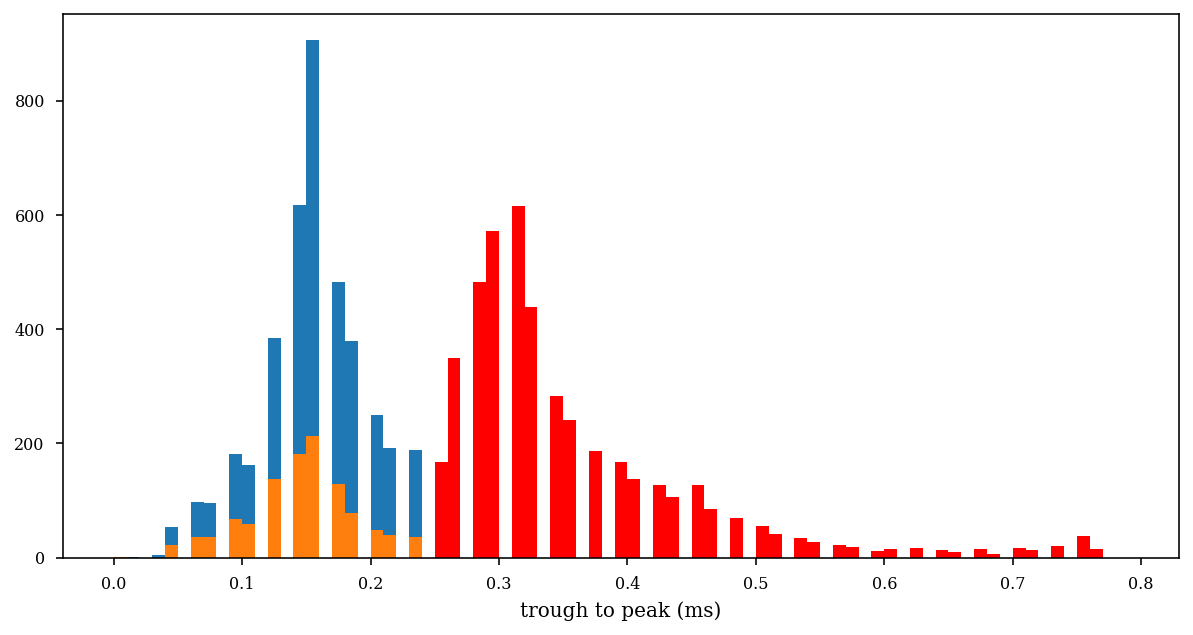

In [26]:
plt.figure(figsize=(10,5))
plt.hist(df_cell_class.trough_to_peak,bins=np.arange(0,.8,.01))


int_idx = (df_cell_class.avg_fr >= 5) & (df_cell_class.trough_to_peak < 0.25)
pyr_idx = (df_cell_class.trough_to_peak >= 0.25)

plt.hist(df_cell_class.trough_to_peak[int_idx],bins=np.arange(0,.8,.01))

plt.hist(df_cell_class.trough_to_peak[pyr_idx],bins=np.arange(0,.8,.01),color='red')
plt.xlabel('trough to peak (ms)')
plt.show()

# plot histograms

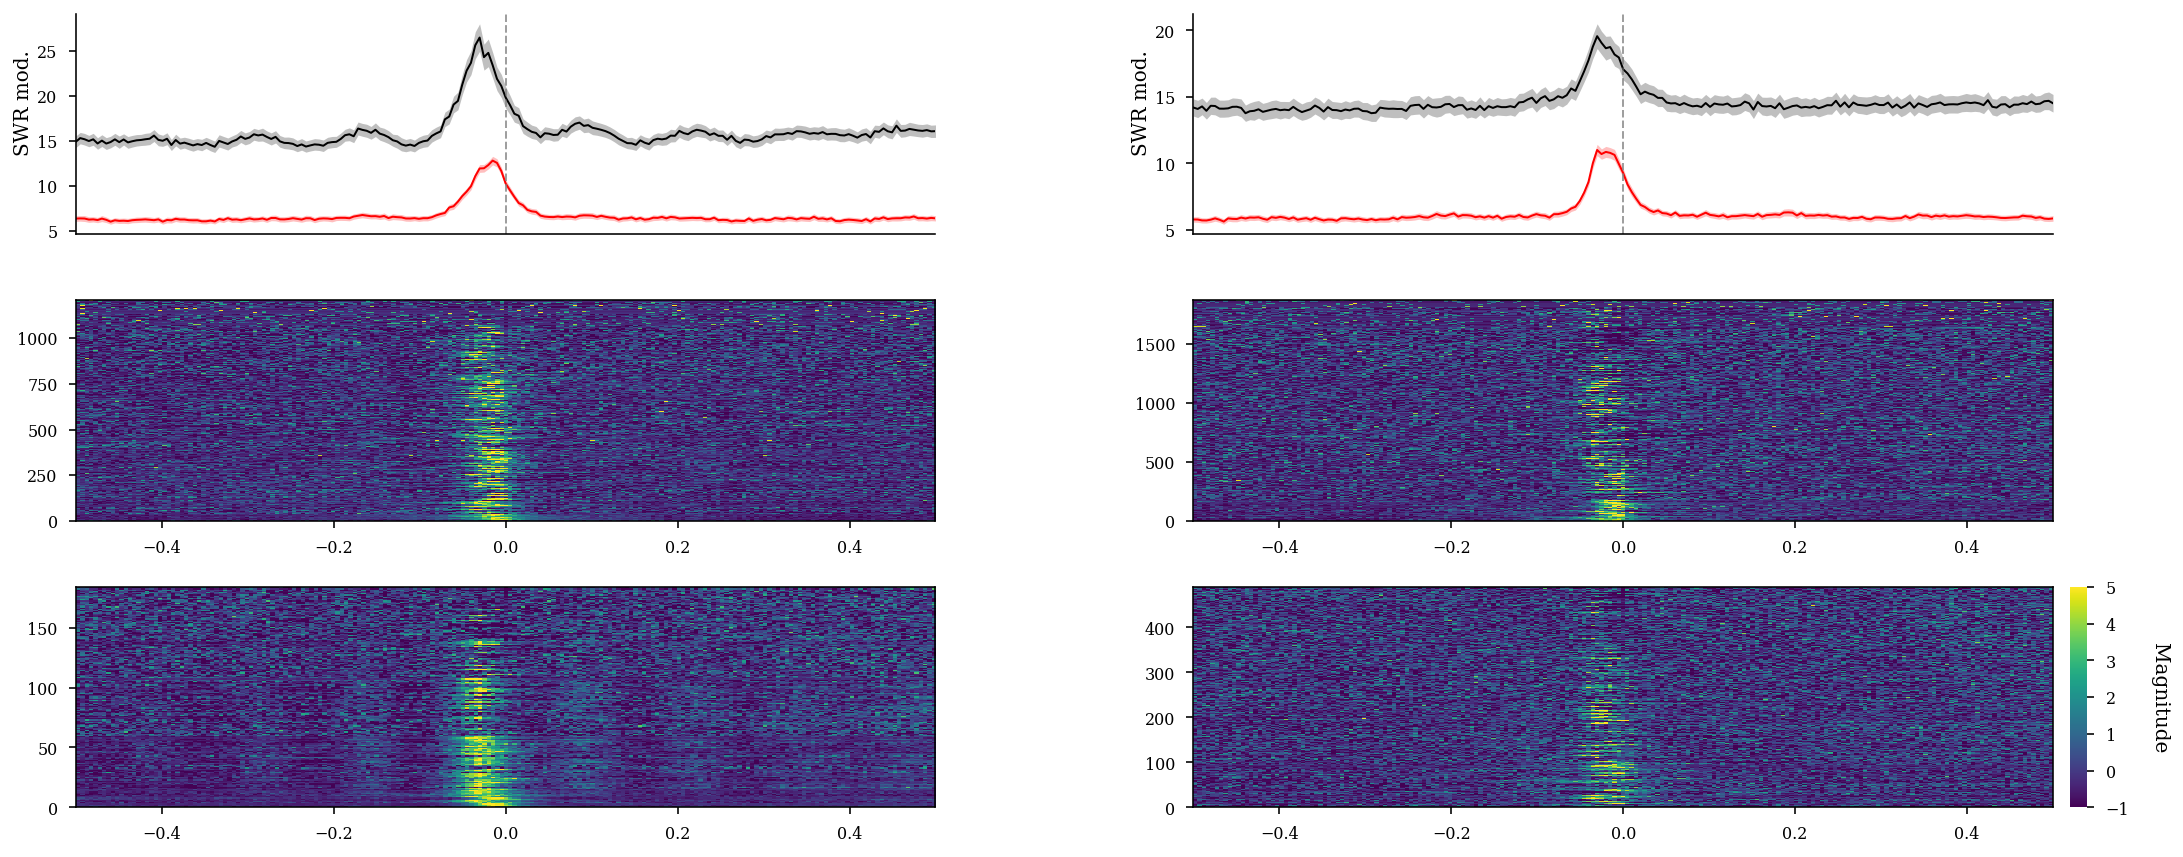

In [168]:
def plot_mean_shadded_lines(h0,idx,ax,color,cell_type):
    # select data
    h0_current = h0[idx]
    # remove rows with nans
    h0_current = h0_current[np.sum(np.isnan(h0_current),axis=1) == 0]
    # find center
    idx = np.linspace(-.5,.5,h0_current.shape[1]) == 0
    # sort by center value
    h0_current = h0_current[np.argsort(h0_current[:,idx].flatten()),:]
    # plot line
    plot_mod_lines(h0_current,ax,color,cell_type)
    return h0_current

n_ripples = 100

fig, axs = plt.subplots(3,2, figsize=set_size('thesis', fraction=3, subplots=(2,3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.3)
axs = axs.ravel()  


idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & pyr_idx
h0_current = plot_mean_shadded_lines(h0,idx,axs[0],'red',"pyr")

h0_current = zscore(h0_current,axis=1)
axs[2].imshow(h0_current,aspect='auto',cmap = "viridis",
           extent = [-0.5 , 0.5, 0 , len(h0_current)],vmin=-1,vmax=5)


idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & int_idx
h0_current = plot_mean_shadded_lines(h0,idx,axs[0],'black',"int")

h0_current = zscore(h0_current,axis=1)
axs[4].imshow(h0_current,aspect='auto',cmap = "viridis",
           extent = [-0.5 , 0.5, 0 , len(h0_current)],vmin=-1,vmax=5)



idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & pyr_idx
h0_current = plot_mean_shadded_lines(h0,idx,axs[1],'red',"pyr")

h0_current = zscore(h0_current,axis=1)
axs[3].imshow(h0_current,aspect='auto',cmap = "viridis",
           extent = [-0.5 , 0.5, 0 , len(h0_current)],vmin=-1,vmax=5)


idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & int_idx
h0_current = plot_mean_shadded_lines(h0,idx,axs[1],'black',"int")

h0_current = zscore(h0_current,axis=1)
im = axs[5].imshow(h0_current,aspect='auto',cmap = "viridis",
           extent = [-0.5 , 0.5, 0 , len(h0_current)],vmin=-1,vmax=5)


# set up parameters for colorbar
axins = inset_axes(axs[5],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=axs[5].transAxes,
                   borderpad=0,
                   )
# plot colorbar
cbar = fig.colorbar(im,ax=axs[5],cax=axins)
cbar.set_label('Magnitude', rotation=270, labelpad=20)
cbar.outline.set_visible(False)


## Ripple modulation with firing rate

Text(0.5, 1.0, 'Pyramidal cells')

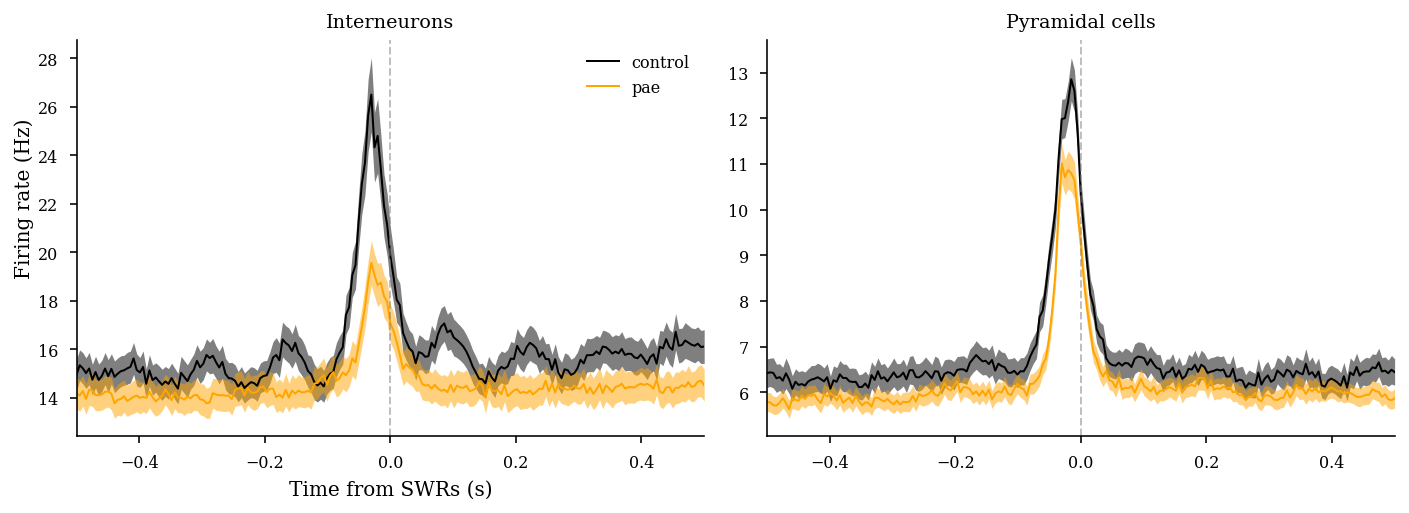

In [14]:
n_ripples = 100

fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=2, subplots=(1,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=.1)
axs = axs.ravel()  

x = np.linspace(-.5,.5,h0.shape[1]) 
h0_current = h0[(df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & int_idx]
h0_current = h0_current[np.sum(np.isnan(h0_current),axis=1) == 0]
m = h0_current.mean(0)
v = h0_current.std(0) / np.sqrt(h0_current.shape[0])
axs[0].plot(x,h0_current.mean(0), label = 'control', color = 'black', linewidth = 1)
axs[0].fill_between(x, m-v, m+v, color = 'black', alpha = 0.5, linewidth =0)

h0_current = h0[(df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & int_idx]
h0_current = h0_current[np.sum(np.isnan(h0_current),axis=1) == 0]
m = h0_current.mean(0)
v = h0_current.std(0) / np.sqrt(h0_current.shape[0])
axs[0].plot(x,h0_current.mean(0), label = 'pae', color = 'orange', linewidth = 1)
axs[0].fill_between(x, m-v, m+v, color = 'orange', alpha = 0.5, linewidth =0)

axs[0].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
axs[0].set_xlim(-.5,.5)
axs[0].set_ylabel("Firing rate (Hz)", labelpad = 2, y = 0.6)
axs[0].legend(edgecolor = None, facecolor = None, frameon = False, loc = 'upper right',)
axs[0].set_xlabel('Time from SWRs (s)')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].set_title('Interneurons')


x = np.linspace(-.5,.5,h0.shape[1]) 
h0_current = h0[(df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & pyr_idx]
h0_current = h0_current[np.sum(np.isnan(h0_current),axis=1) == 0]
m = h0_current.mean(0)
v = h0_current.std(0) / np.sqrt(h0_current.shape[0])
plt.plot(x,h0_current.mean(0), label = 'control', color = 'black', linewidth = 1)
plt.fill_between(x, m-v, m+v, color = 'black', alpha = 0.5, linewidth =0)

h0_current = h0[(df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & pyr_idx]
h0_current = h0_current[np.sum(np.isnan(h0_current),axis=1) == 0]
m = h0_current.mean(0)
v = h0_current.std(0) / np.sqrt(h0_current.shape[0])
axs[1].plot(x,h0_current.mean(0), label = 'pae', color = 'orange', linewidth = 1)
axs[1].fill_between(x, m-v, m+v, color = 'orange', alpha = 0.5, linewidth =0)

axs[1].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
axs[1].set_xlim(-.5,.5)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()
axs[1].set_title('Pyramidal cells')


## ripple modulation with z score

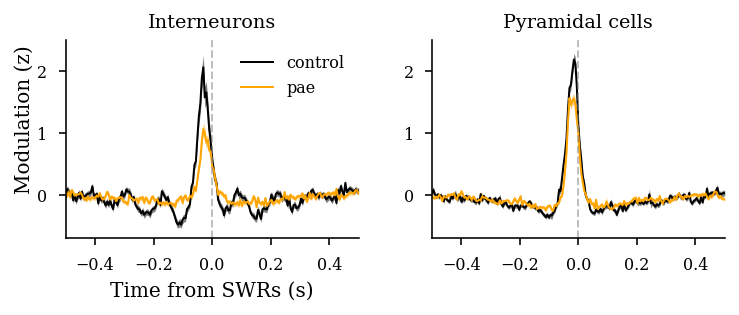

In [108]:
def plot_this_plot(hist,hist_null,idx,ax,label,color,color_2):
    x = np.linspace(-.5,.5,hist.shape[1]) 
    
#     # plot null
#     hist_curr = hist_null[idx]
#     hist_curr = hist_curr[np.sum(np.isnan(hist_curr),axis=1) == 0]
#     ax.plot(x,hist_curr.mean(0), '-',alpha=1, label = label+' null', color = color_2, linewidth = 1)
    
    # plot observed
    hist_curr = hist[idx]
    hist_curr = hist_curr[np.sum(np.isnan(hist_curr),axis=1) == 0]
    m = hist_curr.mean(0)
    v = hist_curr.std(0) / np.sqrt(hist_curr.shape[0])
    ax.plot(x,m, label = label, color = color, linewidth = 1)
    ax.fill_between(x, m-v, m+v, color = color, alpha = 0.5, linewidth = 0)
    


fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=1, subplots=(1,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.25)
axs = axs.ravel()  

idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & int_idx
plot_this_plot(z,z_null,idx,axs[0],'control','black','#1A3947')

idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & int_idx
plot_this_plot(z,z_null,idx,axs[0],'pae','orange','#EFBD9D')

axs[0].set_ylim(-.7,2.5)

axs[0].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
axs[0].set_xlim(-.5,.5)
axs[0].set_ylabel("Modulation (z)", labelpad = 2, y = 0.6)
axs[0].legend(edgecolor = None, facecolor = None, frameon = False, loc = 'upper right',)
axs[0].set_xlabel('Time from SWRs (s)')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].set_title('Interneurons')


idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & pyr_idx
plot_this_plot(z,z_null,idx,axs[1],'control','black','#1A3947')

idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & pyr_idx
plot_this_plot(z,z_null,idx,axs[1],'pae','orange','#EFBD9D')

axs[1].set_ylim(-.7,2.5)

axs[1].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
axs[1].set_xlim(-.5,.5)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()
axs[1].set_title('Pyramidal cells')

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\z_mod_int_pyr.svg',dpi=900,bbox_inches='tight')
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\z_mod_int_pyr.pdf',dpi=900,bbox_inches='tight')

# compare number of swr modulated interneurons

         sig  notsig
control   42     142
pae       68     422
Chi-squared test statistic without Yates correction (Scipy): 7.843429249927203
P-value without Yates correction (Scipy): 0.005100575718026312


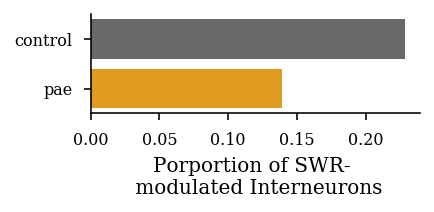

In [165]:
num_sig_control = sum(df_cell_class.sig_center & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & int_idx)
num_sig_pae = sum(df_cell_class.sig_center & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & int_idx)

num_not_sig_control = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & int_idx)
num_not_sig_pae = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & int_idx)

ar = np.array([[num_sig_control,num_not_sig_control],[num_sig_pae,num_not_sig_pae]])
df = pd.DataFrame(ar,columns = ["sig","notsig"])
df.index = ["control","pae"]
print(df)

tstat_scipy,pval_scipy,ddof_scipy,exp_scipy=chi2_contingency(df, correction=False) # "correction=False" means no Yates' correction is used! 
print("Chi-squared test statistic without Yates correction (Scipy): " + str(tstat_scipy))
print("P-value without Yates correction (Scipy): " + str(pval_scipy))

df['porportion'] = df.sig / df.sum(axis=1)

fig, axs = plt.subplots(1,1, figsize=set_size('thesis', fraction=.5, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.5)


# Create an array with the colors you want to use
colors = ['dimgrey','#ffa500ff']

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

ax = sns.barplot(x="porportion", y=df.index, data=df)
plt.xlabel('Porportion of SWR- \n modulated Interneurons')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.show()
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\porportion_mod_fig.pdf',dpi=900,bbox_inches='tight')

# # pyr cells
# num_sig_control = sum(df_cell_class.sig_center & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & pyr_idx)
# num_sig_pae = sum(df_cell_class.sig_center & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & pyr_idx)

# num_not_sig_control = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & pyr_idx)
# num_not_sig_pae = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & pyr_idx)

# ar = np.array([[num_sig_control,num_not_sig_control],[num_sig_pae,num_not_sig_pae]])
# df = pd.DataFrame(ar,columns = ["sig","notsig"])
# df.index = ["control","pae"]
# print(df)

# tstat_scipy,pval_scipy,ddof_scipy,exp_scipy=chi2_contingency(df, correction=False) # "correction=False" means no Yates' correction is used! 
# print("Chi-squared test statistic without Yates correction (Scipy): " + str(tstat_scipy))
# print("P-value without Yates correction (Scipy): " + str(pval_scipy))

# df['porportion'] = df.sig / df.sum(axis=1)

# ax = sns.barplot(x="porportion", y=df.index, data=df)

# compare SWR energy

(-0.042080745341614906, 'negligible')
(-0.6281386124588306, 'large')


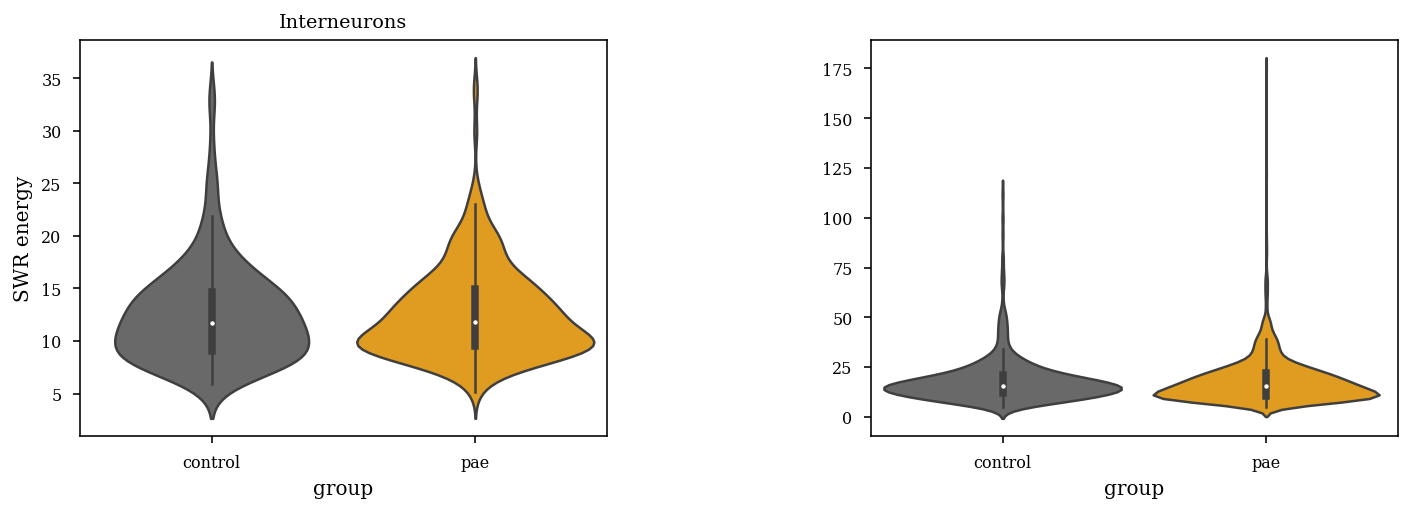

In [125]:
fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.5)
axs = axs.ravel()

# set params
x = 'group'
linewidth = 1.25
width = .9

# Create an array with the colors you want to use
colors = ['dimgrey','#ffa500ff']

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# plot

idx = (df_cell_class.n_ripples >= 100) & int_idx
axs[0] = sns.violinplot(x=x, y="swr_energy", data=df_cell_class[idx],
               linewidth=linewidth,width=width,ax=axs[0])
# axs[0].set_ylim(0,180)

axs[0].set_ylabel('SWR energy')
axs[0].set_title('Pyramidal cells')
axs[0].set_title('Interneurons')
print(cliffsDelta(df_cell_class.swr_energy[idx & (df_cell_class.group == "control")], df_cell_class.swr_energy[idx & (df_cell_class.group == "pae")]))



idx = (df_cell_class.n_ripples >= 100) & pyr_idx

axs[1] = sns.violinplot(x=x, y="swr_energy", data=df_cell_class[idx],
               linewidth=linewidth,width=width,ax=axs[1])
axs[1].set_ylabel('')
# axs[1].set_ylim(0,180)
print(cliffsDelta(df_cell_class.swr_energy[idx & (df_cell_class.group == "control")], df_cell_class.swr_energy[idx & (df_cell_class.group == "pae")]))



# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\SWRenergy_fig.svg',dpi=900,bbox_inches='tight')

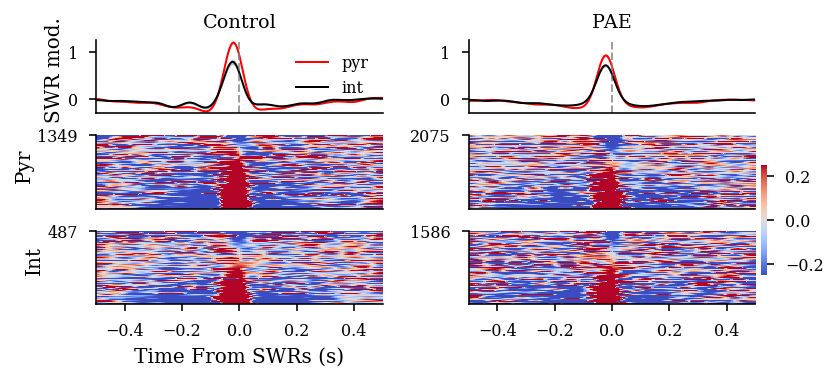

In [167]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def mod_maps(z,df_cell_class,cell_type):
    z_smooth = gaussFilt(z[df_cell_class.cell_type == cell_type,:], (5,))
    z_smooth = np.delete(z_smooth, np.sum(np.isnan(z_smooth),axis=1) > 0, 0)
    idx = np.linspace(-.5,.5,z_smooth.shape[1]) == 0
    z_smooth = z_smooth[np.argsort(z_smooth[:,idx].flatten()),:]
    return z_smooth

def plot_mod_lines(z_smooth,ax,color,cell_type,legend_=0):
    x = np.linspace(-.5,.5,z_smooth.shape[1]) 
    m = z_smooth.mean(0)
    v = z_smooth.std(0) / np.sqrt(z_smooth.shape[0])
    ax.plot(x,z_smooth.mean(0), label = cell_type, color = color, linewidth = 1)
    ax.fill_between(x, m-v, m+v, color = color, alpha = 0.25, linewidth =0)
    ax.axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
    ax.set_xlim(-.5,.5)
    ax.set_ylabel("SWR mod.", labelpad = 2, y = 0.6)
    ax.set_xticks([], [])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if legend_ == 1:
        ax.legend(edgecolor = None, facecolor = None, frameon = False, loc = 'upper right',)
    return min(m-v), max(m+v)

def plot_mod_maps(z_smooth,ax):
    im = ax.imshow(z_smooth,aspect='auto',cmap = "coolwarm",
              vmin=-.25,vmax=.25,
             extent = [-0.5 , 0.5, 0 , len(z_smooth)])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.set_yticks([len(z_smooth)])
    return im

    
fig, axs = plt.subplots(3,2, figsize=set_size('thesis', fraction=1, subplots=(2,3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.3)
axs = axs.ravel()    

n_ripples = 100
# plot control
# plot pyr
# idx = df_cell_class.group=="control"
idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control")

axs[0].set_title('Control')
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"pyr")   
min_mod,max_mod=plot_mod_lines(z_smooth,axs[0],'red',"pyr")
axs[0].set_ylim([min_mod-.03,max_mod+.02])

plot_mod_maps(z_smooth,axs[2])
axs[2].set_ylabel("Pyr", labelpad = 2, y = 0.6)
axs[2].set_xticks([], [])

# plot interneurons
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"int")
plot_mod_lines(z_smooth,axs[0],'black',"int",legend_=1)
plot_mod_maps(z_smooth,axs[4])
axs[4].set_ylabel("Int", labelpad = 2, y = 0.6)
axs[4].set_xlabel('Time From SWRs (s)')

# plot pae
# plot pyr
idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae")

# idx = df_cell_class.group=="pae"
axs[1].set_title('PAE')
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"pyr")
plot_mod_lines(z_smooth,axs[1],'red',"pyr")
axs[1].set_ylim([min_mod-.03,max_mod+.02])

plot_mod_maps(z_smooth,axs[3])
axs[3].set_xticks([], [])

# plot interneurons
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"int")
plot_mod_lines(z_smooth,axs[1],'black',"int")
axs[1].set_ylabel(" ")
im = plot_mod_maps(z_smooth,axs[5])

# add colorbar theme
axins = inset_axes(axs[5],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, .4, 1, 1.5),
                   bbox_transform=axs[5].transAxes,
                   borderpad=0,
                   )
# plot colorbar
cbar = fig.colorbar(im,ax=axs[5],cax=axins)

# cbar.set_label('Magnitude', rotation=270, labelpad=20)
cbar.outline.set_visible(False)

# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\mod_fig.pdf',dpi=900,bbox_inches='tight')
# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\mod_fig.svg',dpi=900,bbox_inches='tight')

# plot example raster 

In [ ]:
# session = "LEM3216_S20190805141510"
# # find index of first mention of session
# rip_n = np.where(df_swr.session == session)[0][0]
# # load spikes
# spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# # get ripple times
# peak_time = df_swr.peak_time[df_swr.session == session]

# # [3,7]

In [72]:
session = "LEM3216_S20190822113344"
# find index of first mention of session
rip_n = np.where(df_swr.session == session)[0][0]
# load spikes
spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# get ripple times
peak_time = df_swr.peak_time[df_swr.session == session]

# [3,7]

session            LEM3216_S20190822113344
tetrode                           TT13.mat
cell                                    69
flipped                                  1
peak_to_trough                    0.234375
trough_to_peak                       0.125
spk_wavelet                        1.11383
local_variation                   0.492183
avg_fr                             32.6154
asymmetry                          2.66555
cell_type                              int
swr_energy                         13.2648
swr_energy_null                     7.3332
group                              control
n_ripples                              551
sig_center                           False
Name: 6161, dtype: object
session            LEM3216_S20190822113344
tetrode                           TT13.mat
cell                                   144
flipped                                  1
peak_to_trough                     0.21875
trough_to_peak                     0.34375
spk_wavelet                 

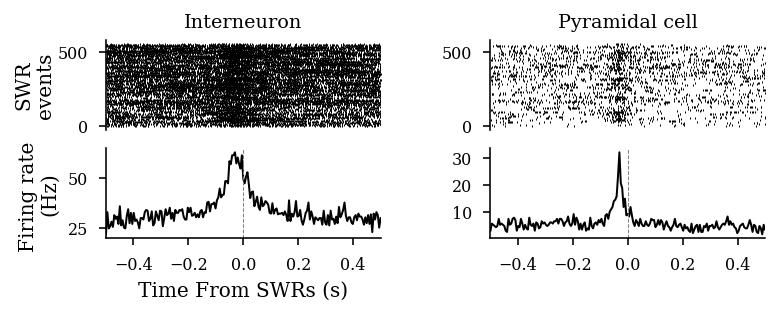

In [107]:
def swr_modulation(spikes,peak_time,binsize=0.005):
    # create raster centered over each ripple with a 1 second window
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))

    # bin cell into 5ms bins 
    h0, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0 / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,30)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, x, y

cell_n = 3
print(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=1, subplots=(1,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.4)
axs = axs.ravel()

axs[0].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
axs[0].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[0].set_xticks([], [])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].set_xlim(-.5,.5)
axs[0].set_title('Interneuron')

axs[2].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
axs[2].set_ylabel('Firing rate \n(Hz)', verticalalignment = 'bottom')
axs[2].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].get_xaxis().tick_bottom()
axs[2].get_yaxis().tick_left()
axs[2].set_xlim(-.5,.5)
axs[2].set_xlabel('Time From SWRs (s)')


cell_n = 7
print(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

axs[1].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
# axs[1].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[1].set_xticks([], [])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()
axs[1].set_xlim(-.5,.5)
axs[1].set_title('Pyramidal cell')


axs[3].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
# axs[3].set_ylabel('Firing rate (Hz)', verticalalignment = 'bottom')
axs[3].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].get_xaxis().tick_bottom()
axs[3].get_yaxis().tick_left()
axs[3].set_xlim(-.5,.5)
# axs[3].set_xlabel('Time From SWRs (s)')

# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\mod_example_fig_int.pdf',dpi=900,bbox_inches='tight')
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\mod_example_fig_int.svg',dpi=900,bbox_inches='tight')

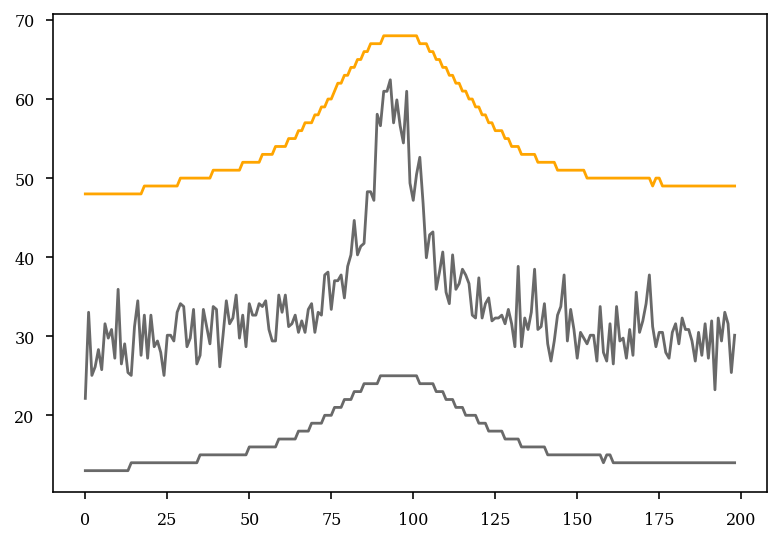

In [192]:
from scipy import signal

def local_firfilt( x, W ):
    C = int(len(W))
    D = int(np.ceil(C / 2) - 1)
    xx = [np.flipud(x[0 : C]), x, np.flipud(x[len(x) - C : len(x)])]
    xx = list(itertools.chain(*xx))
    Y = signal.lfilter(W,1,xx)
    Y = Y[C + D : len(Y) - C + D]
    return Y

def local_gausskernel(sigma,N):
    x = np.arange(-(N-1) / 2, (N-1) / 2)
    k = 1 / (2*np.pi*sigma) * np.exp(-(x**2 / 2 / sigma**2 ))
    return k

def cch_conv(cch,W=30,HF=0.6):
    # Stark and Abeles JNM 2009
    SDG = W / 2
    win = local_gausskernel(SDG, 6 * SDG + 3)
    cidx = int(SDG * 3 + 1)
    win[cidx] = win[cidx] * ( 1 - HF )
    win = win / sum( win )
    pred = local_firfilt( cch, win )
    pvals = 1 - poisson.cdf(cch - 1, pred) - poisson.pmf(cch, pred) * 0.5
    qvals = 1 - pvals
    return pvals, pred, qvals

def sig_mod(cch,binsize=0.005,sig_window=0.2,alpha=0.001):
    pvals, pred, qvals = cch_conv(cch)

    nBonf = int(sig_window/binsize)*2;
    hiBound = poisson.ppf(1-alpha/nBonf, pred)
    loBound = poisson.ppf(alpha/nBonf, pred)

    center_bins = np.arange(int(len(cch)/2 - .1/binsize), int(len(cch)/2 + .1/binsize))
    sig = (max(cch[center_bins]) > max(hiBound)) | (min(cch[center_bins]) < min(loBound))
    return sig, hiBound, loBound

sig, hiBound, loBound = sig_mod(hist,alpha=0.05)

plt.plot(hist)
plt.plot(hiBound)
plt.plot(loBound)

# testing

In [ ]:
cell = 13
def swr_modulation(spikes,):
    # create raster centered over each ripple with a 1 second window
    x = []
    y = []
    peak_time = df_swr.peak_time[df_swr.session == df_swr.iloc[rip_n].session]
    for i,r in enumerate(peak_time):
        idx = (spikes[cell] > r - .5) & (spikes[cell] < r + .5)
        cur_spks = spikes[cell][idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))

    # bin cell into 5ms bins 
    hist, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,0.005))
    # normalize into firing rate
    hist = hist / (len(np.unique(y))*0.005)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(hist,30)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z_hist = (hist - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z_hist**2))

print(swr_energy)

# plot raster, histogram, expected rates, and z-scored modulation
fig, axs = plt.subplots(3,1, figsize=set_size('thesis', fraction=1, subplots=(3,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

axs[0].plot(x,y,'|',color='black',markersize=1,mew = 0.5)
axs[0].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[0].set_xticks([], [])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()

axs[1].plot(np.linspace(-0.5,0.5,len(hist)),gaussFilt(hist, (2,)),color='red',linewidth = 1,label = '')
axs[1].plot(np.linspace(-0.5,0.5,len(hist)),hist_smooth,color='black',linewidth = 1, label = 'Jitter')
axs[1].set_xticks([], [])
axs[1].set_ylabel('Rate \n (Hz)', verticalalignment = 'top', labelpad = 20)
axs[1].legend(edgecolor = None, facecolor = None, frameon = False, loc = 'lower left')	
axs[1].axvline(0, color = 'grey', linewidth = 0.5)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()

axs[2].plot(np.linspace(-0.5,0.5,len(z_hist)), gaussFilt(z_hist, (5,)),color='red',linewidth = 1)
axs[2].set_ylabel('Modulation\n(z)', verticalalignment = 'bottom')
axs[2].axvline(0, color = 'grey', linewidth = 0.5)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].get_xaxis().tick_bottom()
axs[2].get_yaxis().tick_left()
